# Positional encodings: overview and exploration

Brief: implement and explore positional encodings for Transformers to gain understanding and intuition

Author: Stephen Menary, sbmenary@gmail.com

Date: 12/12/2022

Last edit: 13/12/2022

---

## Intro

In this notebook we will implement the positional encodings from the original "Attention is all you need" (AIAYN) paper: https://arxiv.org/abs/1706.03762

Whilst Transformers are famously successful in NLP for modelling sequences of words, in general their inductive bias is appropriate for modelling any sequential data. Since every sequence element is initially tokenised, we will simply discuss sequences of tokens, without being specific to NLP.

Attention layers have no built-in mechanism for understanding the position of each token in the sequence. If we feed raw token embeddings it into an attention layer, it will only see a "bag of tokens", not a sequence. This would be fine for modelling sets, which have no positional information, but it is not appropriate for modelling sequences, for which the token order is the defining structure.

We therefore need a way to include this positional information. There are two ways to do this:

1. **Modify the architecture so that it uses different weights for different absolute positions.** At first glance, this architecture appeared to be simply a feed-forward neural network, but actually it must be constructed more like a graph network to allow for variable sequence sizes. At least in early layers, our model is sensitive to the _absolute_ position of every token in the sequence - although later layers may connect to multiple inputs and learn to generalise in this way. Sometimes we want to depend on absolute position, when this represents something fundamental about the structure of the data, but not where relative positions are more important, e.g. in NLP where "the fast green car" has the same meaning regardless of whether it occurs at index 0 or 100. Futhermore, to fit this model, we require training data in which token-combinations occur at all possible positions. This is a poor inductive bias and so we are penalised with very poor data-efficient and training stability. 
2. **Modify the architecture so that it uses different weights for different relative positions.** This is closer to something like a graph convolutional network, in which we allow each token to talk to its neighbours and propagate short-range correlations. Maybe this is a good idea? One downside is that it is hard to propagate long-range correlations, since a very deep network would be needed.
3. **Modify the embeddings to include absolute positional information.** This is sort-of what we do. Indeed, without using an explicit graph network, this is basically our only option. However, we still have work to do - we want to define our encodings in a way which has nice properties (e.g. all tokens separate by 5 indices have similar relationships in embedding space, which the model can learn to generalise over).
4. **Modify the embeddings to include relative positional information.** This is not possible. To include relative position information would require context-dependent learning, for which we must implement a whole NLP algorithm, which is the task we are trying to solve in the first place!


So we want to encode positional information in the input itself. We do this by adding information to the token embedding. Say that a token is initially embedded as some $d$-dimensional vector $v_\mathrm{token}^{(d)}$. We aim to create a positional embedding $v_\mathrm{pos}^{(d)}$ which is also $d$-dimensional. We do this so that we can represent the final token using a simple sum
\begin{equation}
v_\mathrm{embed}^{(d)} ~=~ v_\mathrm{token}^{(d)} ~+~ v_\mathrm{pos}^{(d)}
\end{equation}

Of course, an alternative approach would be to pad the embedding with additional dimensions that contain the positional information. This would be less efficient (requires longer vectors) but avoids scrambling the information regarding position and token. I'm honestly not sure why we don't do this instead. Of course, the ideal situation is that the sets $\{v_\mathrm{token}^{(d)}\}$ and $\{v_\mathrm{pos}^{(d)}\}$ are defined in such a way that $\{v_\mathrm{embed}^{(d)}\}$ are unique for all token/position pairs.


---

## Positional encoding

It is possible to define the positional encodings in many ways, including through learning - it is just a classic embedding problem. However, we choose to perform an analytic encoding because
- it is efficient to execute
- it does not require us to perform a separate training task 
- we may precisely control the behaviour, so there are no unexpected results

Of course, the simplest encoding would be a scalar containing the position $x$ itself. This does not depend on sequence length, which would be a difficult confounding variable to account for, and (for the decoder) may not even be defined at run time. In fact, this encoding seems relatively sensible, and I feel like we could use it. A couple of ideas for why we don't use it are:
- would it be too easy to learn absolute positions rather than relative ones?
- new sequence lengths result in encodings outside of the previously observed domain, and are strictly unbounded

Instead, the original AIAYN paper uses a clever encoding which has four useful properties:
- the encoding does not depend on sequence length
- the encoding is bounded in a natural domain of $\left[-1,~+1\right]$
- the encoding for position $k+x$ is a linear transformation of the encoding for position $x$. Furthermore, this transformation depends only on $k$, a simple rule which it should be possible for the attention layers to understand. N.B. this is also true for any simple linear encoding!
- if the Transformer encounters a new sequence length during training, _in principle_ it can still understand the relative positions by applying the learned rules. N.B. this is also true for any simple linear encoding!


Say that we have a vector encoding $v_\alpha\left(x\right)$, where $\alpha$ label vector indices. To achieve this linearity, we want to construct this such that
\begin{equation}
    v_\alpha\left(x+k\right) ~=~ M_{\alpha}\left(k\right) ~+~ \sum_{\beta} N_{\alpha,\beta}\left(k\right) ~\cdot~ v_\alpha\left(k\right)
\end{equation}
where $k$ is some offest, and $M$ ($N$) is a vector (matrix) that depends only on $k$. This formulation means that all encodings separated by the same distance are transformed by the same simple linear function, which may be easy for the following attention layers to generalise trends from.

We note that this formulation cannot be made self-consistent for any arbitrary functions $M$ and $N$, because we have consistency requirements between $v\left(x\right)$, $v\left(x+k\right)$, $v\left(x+n\right)$ and $v\left(x+k+n\right)$. We will now consider a couple of examples.

The simplest case, "the encoding is a simple linear function of $x$", corresponding to the choice $M_\alpha\left(k\right) = c_\alpha \cdot k$ and $N_{\alpha,\beta}\left(k\right) = 0$. One thing to note is that this is unbounded and may span many orders of magnitude, e.g. for a sequence of length $1k$ we would have $x \in \{0, 1, \dots, 1k\}$ and so $v_\alpha \in \{0, c_\alpha, \dots, 1k\cdot c_\alpha\}$. This means that the encodings span three orders of magnitude. This is perfectly natural when we want to be highly sensitive to the _absolute_ positions, but not very unnatural when we only care about sensitivity to relative positions.

Another simple case would be "the encoding is a simple geometric sequence in $x$", corresponding to the choice $M_\alpha\left(k\right) = 0$ and $N_{\alpha,\beta}\left(k\right) = c_{\alpha}\delta_{\alpha,\beta}$. We essentially stretch each component $v_\alpha$ by a different _factor_ every step. This suffers from the same order-of-magnitude problem as before, but even worse, because our encodings essentially follow an exponential function! Unless the geometric factor is defined on the domain $(0,1]$, in which case we get an exponential decay. This actually solves the boundedness problem, and does something to mitigate the order-of-magnitude problem by making the differences slow down as the length increases, but we still have some order-of-magnitude problem, and we have now introduced a progression towards an asymptote, i.e. saturation. Saturation can be a problem for numerical precision and stability.

Both the linear and geometric encodings are very learnable for regular neurons constructed of a bias and weights, where the bias values describe a linear trend, and the weights describe a geometric trend, although we note that a single neuron cannot describe multiple different stretches/translations in different directions, in which case we can speculate that a 1D encoding would seem most appropriate.

To compress the encodings onto a single order of magnitude, we may choose $N_{\alpha,\beta}\left(k\right) = f_\alpha\left(k\right) \delta_{\alpha,\beta}$ for some nonlinear function $f_\alpha(k)$. This is a diagonal matrix where the scale factors along the diagonal are nonlinear, and may be designed to saturate according to e.g. a logistic function. I think that our encodings would have a shape like $1 - e^{-x}$ or $\log x$ in each component. This also works in a sense: we have achieved our aims of linearity and compressing all encodings onto a single natural scale. However, this saturation still poses a stability problem.

Okay, so ideally we want to formulate our encodings in a way that avoids saturation. We can do this using $M=0$ and $N$ is a unitary matrix. Our progression is therefore a _rotation_ $N=R(\theta)$ about a single angle $\theta(k) = \omega \cdot k$. This linear form is needed to satisfy the consistency requirement $v(x+k+n) = R(k) v(x+n) = R(n) v(x+k) = R(k+n) v(x)$. The constant $\omega$ fixes the rotation frequency $f=2\pi \omega$.

So we now have
\begin{equation}
    v\left(x\right) ~=~ R\left(\omega \cdot k\right) v\left(x\right)
\end{equation}
Since this is a rotation about a single angle, it is minimally represented by a 2D vector. Taking $k=2$, we therefore have
\begin{equation}
    \begin{pmatrix}v_1 \\ v_2\end{pmatrix}\left(x+k\right) ~=~ \begin{pmatrix}\cos\omega k & \sin\omega k \\ -\sin\omega k & \cos\omega k \\ \end{pmatrix} \begin{pmatrix}v_1 \\ v_2\end{pmatrix}\left(x\right)
\end{equation}
Now, we encounter a problem. Since our encodings are periodic, there is some ambiguity about whether two different encodings are seperated by $k$, $k+\frac{2\pi}{\omega}$, $k+2\frac{2\pi}{\omega}$ etc. To get around this problem, we may simply introduce a second rotation with a different value of $\omega$! As long as we choose these two different values to have no degenerate points, then this breaks the ambiguity. Let us extend our encoding to a 4D vector with a second orthogonal rotation direction:
\begin{equation}
    \begin{pmatrix}v_1\\v_2\\v_3\\v_4\end{pmatrix}\left(x+k\right) ~=~ \begin{pmatrix}\cos\omega_1 k & \sin\omega_1 k & 0 & 0 \\ -\sin\omega_1 k & \cos\omega_1 k & 0 & 0 \\ 0 & 0 & \cos\omega_2 k & \sin\omega_2 k \\ 0 & 0 & -\sin\omega_2 k & \cos\omega_2 k \\ \end{pmatrix} 
    \begin{pmatrix}v_1\\v_2\\v_3\\v_4\end{pmatrix}\left(x\right)
     ~~~~~~~~~~~~ \text{with}~~ n_1\omega_1 \neq n_2\omega_2 ~\forall~ n_1,n_2 \in \mathbb{N}
\end{equation}

We are almost there. Using only two angles can work in principle, but it may still be difficult for attention layers to pick up on the trend if the rotation frequencies $\{\omega_1,\omega2\}$ are not on a natural scale compared with the scale of data correlations. Instead, for a $d$-dimensional embedding, we choose to use $\frac{d}{2}$ angles which follow a geometric progression of frequencies from $\mathcal{O}(1)$ to $\mathcal{O}(10k)$. Of course, we can always tweak this range for different use-cases. A geometric progression isn nice because there will always be some frequencies at a "natural scale" with respect to any length of data correlation, so no such scales are picked out as special by the encoding, allowing them to be always learned from the data.

Say that $p=\{0,1,\dots,N-1\}$ is the position of a token in a sequence of length $N$. Our encoding is defined as
\begin{equation}
v_{i}^{(d)} ~=~ 
\begin{cases} 
\sin\left( \frac{p}{10000^{i/2d}} \right)  &  \mathrm{if} ~~~ i ~\%~ 2 = 0 \\
\cos\left( \frac{p}{10000^{(i-1)/2d}} \right)  &  \mathrm{if} ~~~ i ~\%~ 2 = 1 \\
\end{cases}
\end{equation}
Note that we can use $i$ or $i-1$ in the second vector, because they are only separated by a constant phase, which is really just a co-ordinate choice. We follow the AIAYN convention and use the same phase for both the $\sin$ and $\cos$ directions of each rotation.

---

##  Visually exploring the encodings

Let us now make some plots to see what these encodings look like in reality. To start with, let us separate out the `sin` and `cos` parts, because the plot looks a bit too _jumpy_ when we alternate between them. First, let us simply visualise the values of all the $d$ embeddings for a variety of different $p$. Since we have two degrees of freedom, this will most naturally be represented by a 2D colour map.


In [43]:
#============================================
#===  Import packages and print versions  ===
#============================================

##  Import Python packages
import sys

##  Import additional packages
import matplotlib as mpl
from   matplotlib import pyplot as plt
import numpy as np

##  Print versions for reproducibility
print(f"Python version is {sys.version}".replace("\n", " | "))
print(f"Matplotlib version is {mpl.__version__}")
print(f"Numpy version is {np.__version__}")


/Users/Ste/miniforge3/envs/tf-sandbox-py3p9/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


Python version is 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:25:14)  | [Clang 12.0.1 ]
Matplotlib version is 3.5.1
Numpy version is 1.21.6
Tensorflow version is 2.8.0


In [2]:
#===============================================
#===  Define sinusoidal positional encoding  ===
#===============================================

def sinusoid_encoding(p, d, phase_offset=0) :
    """
    Create positional encodings for position(s) p using formula. Encodings are calculated as
    sin(p/10000**(i/d) + phase_offset) for i=0,...,d. Use phase_offset=pi/2 for cosine encoding.
    Input:
      >  p, int or shape S
         integer index of token position in sequence. May provide arbitrary shape of such indices.
      >  d, int
         length of encoded vector
      >  phase_offset, float or shape (S, d)
         constant amount to add
    Returns:
      >  array of shape (1,d) or (S,d)
         encoded positions
    """
    ##  Prepare frequencies for sinusoids, with omega = f / 2pi
    i     = np.arange(d)   #  shape (d,)
    omega = 10000**(-i/d)  #  shape (d,)
    ##  Outer product is tensor of all pair-wise combinations of elements of p and omega
    return np.sin(np.outer(p, omega) + phase_offset)   #  shape (S, d)


In [14]:
#=======================================
#===  Define method to plot encoding ===
#=======================================

def create_encoding_plot(encodings, close=True, dpi=100, savefig="", show=True, title="") :
    """
    Create a plot visualising the values of the encoded positions.
    Input:
      >  encodings, shape (N, d)
         encoded positions 
      >  additional optional arguments
    Returns:
      >  matplotlib.figure.Figure
         Figure-type object containing plot
      >  matplotlib.axes._subplots.AxesSubplot
         Axis-type object containing main plot
      >  matplotlib.axes._axes.Axes
         Axis-type object containing colorbar
      >  matplotlib.image.AxesImage
         Image produced by ax.imshow
    """
    
    ##  Get shape of encodings to define aspect ratio (actually transpose is needed)
    shape = np.array(encodings.shape).T
    
    ##  Create figure object
    #fig = plt.figure(figsize=4*shape/shape[1])
    fig = plt.figure(figsize=(8, 5))
    
    ##  Create main plot axis
    ax  = fig.add_axes([0, 0, 0.93, 1])
    ax.tick_params(which="both", axis="both", direction="in", right=True, top=True, labelsize=12)
    ax.set_xlabel("Sequence position", va="top", labelpad=20, fontsize=14)
    ax.set_ylabel("Encoded\n vector  ", va="bottom", ha="right", rotation=0, labelpad=25, fontsize=14)
    ax.grid(True)
    
    ##  Plot main image
    im = plt.imshow(encodings.T, vmin=-1, vmax=1, cmap="bwr", origin="lower", aspect='auto')
    
    ##  Create main plot axis
    cax = fig.add_axes([0.98, 0, 0.02, 1])
    cax.tick_params(which="both", axis="both", direction="in", right=True, top=True, labelsize=12)
    cax.set_ylabel("Encoding\n value", va="bottom", ha="left", rotation=0, labelpad=25, fontsize=14)
    
    ##  Plot colorbar
    plt.colorbar(im, cax=cax)
    
    ##  Add title if provided
    if title :
        ax.set_title(title, fontsize=14, pad=4, va="bottom")

    ##  Save if filename provided
    if savefig :
        fig.savefig(savefig, bbox_inches="tight", dpi=dpi)
        
    ##  Show if requested
    if show :
        plt.show(fig)
       
    ##  Close if requested 
    if close :
        plt.close()
        
    ##  Return
    return fig, ax, cax, im

Creating plot using sin encoding


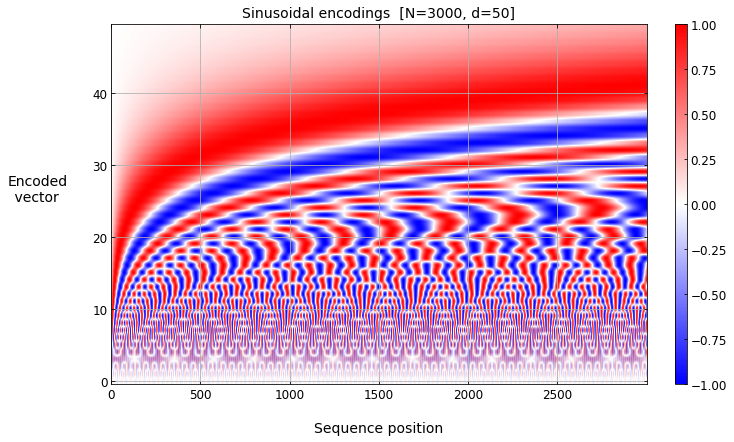

Creating plot using cos encoding


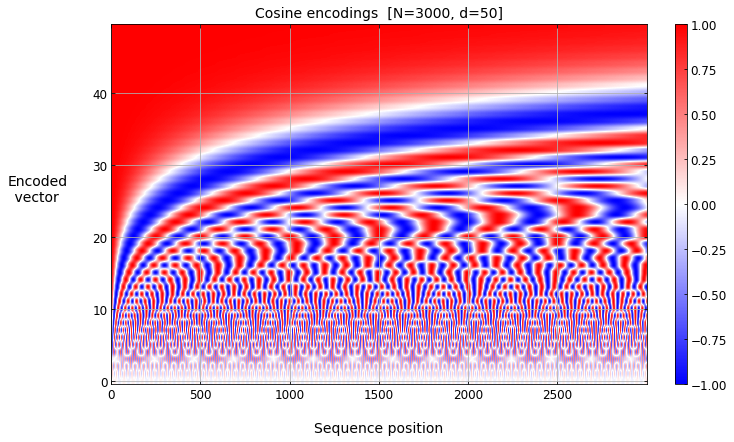

In [30]:
#==================================================
#===  Calculate and plot sine and cos encodings ===
#==================================================

##  Configurable constants
N = 3000  # length of sequence
d = 50    # size of encoding

##  Create sin and cos encodings
sin_encodings = sinusoid_encoding(np.arange(N), d)  #  shape (N, d)
cos_encodings = sinusoid_encoding(np.arange(N), d, phase_offset=np.pi/2)  #  shape (N, d)

##  Make plots
print("Creating plot using sin encoding")
_ = create_encoding_plot(sin_encodings, title=f"Sinusoidal encodings  [N={N}, d={d}]", 
                         savefig="figures/positional_encodings_overview/sin_encoding.pdf")
print("Creating plot using cos encoding")
_ = create_encoding_plot(cos_encodings, title=f"Cosine encodings  [N={N}, d={d}]", 
                         savefig="figures/positional_encodings_overview/cos_encoding.pdf")


We can see
- at all scales of sequence separations, there exist frequencies that can capture token correlations
- encoded features always fall on the interval $[-1,+1]$, maintaining a consistent natural scale.

Question: is there a problem with feeding tokens instead of words? The attention layer will want to say "token A is correlated with tokens B and C as long as B and C are grouped together". But the attention function does not allow for us to attend to combinations of tokens, only individual tokens. Although, these compound correlations are captured by stacking attention layers, like in a CNN, so the information does propagate. Like in a CNN, there will probably be problems if we have too few layers to construct high quality abstract features. How many layers are generally needed? Is this the most effective way?

---

Another interesting exercise is to view slices along the $x$-axis, at different depths within the embedding. We can therefore see how the position dependence is captured across the spectrum of different frequencies.

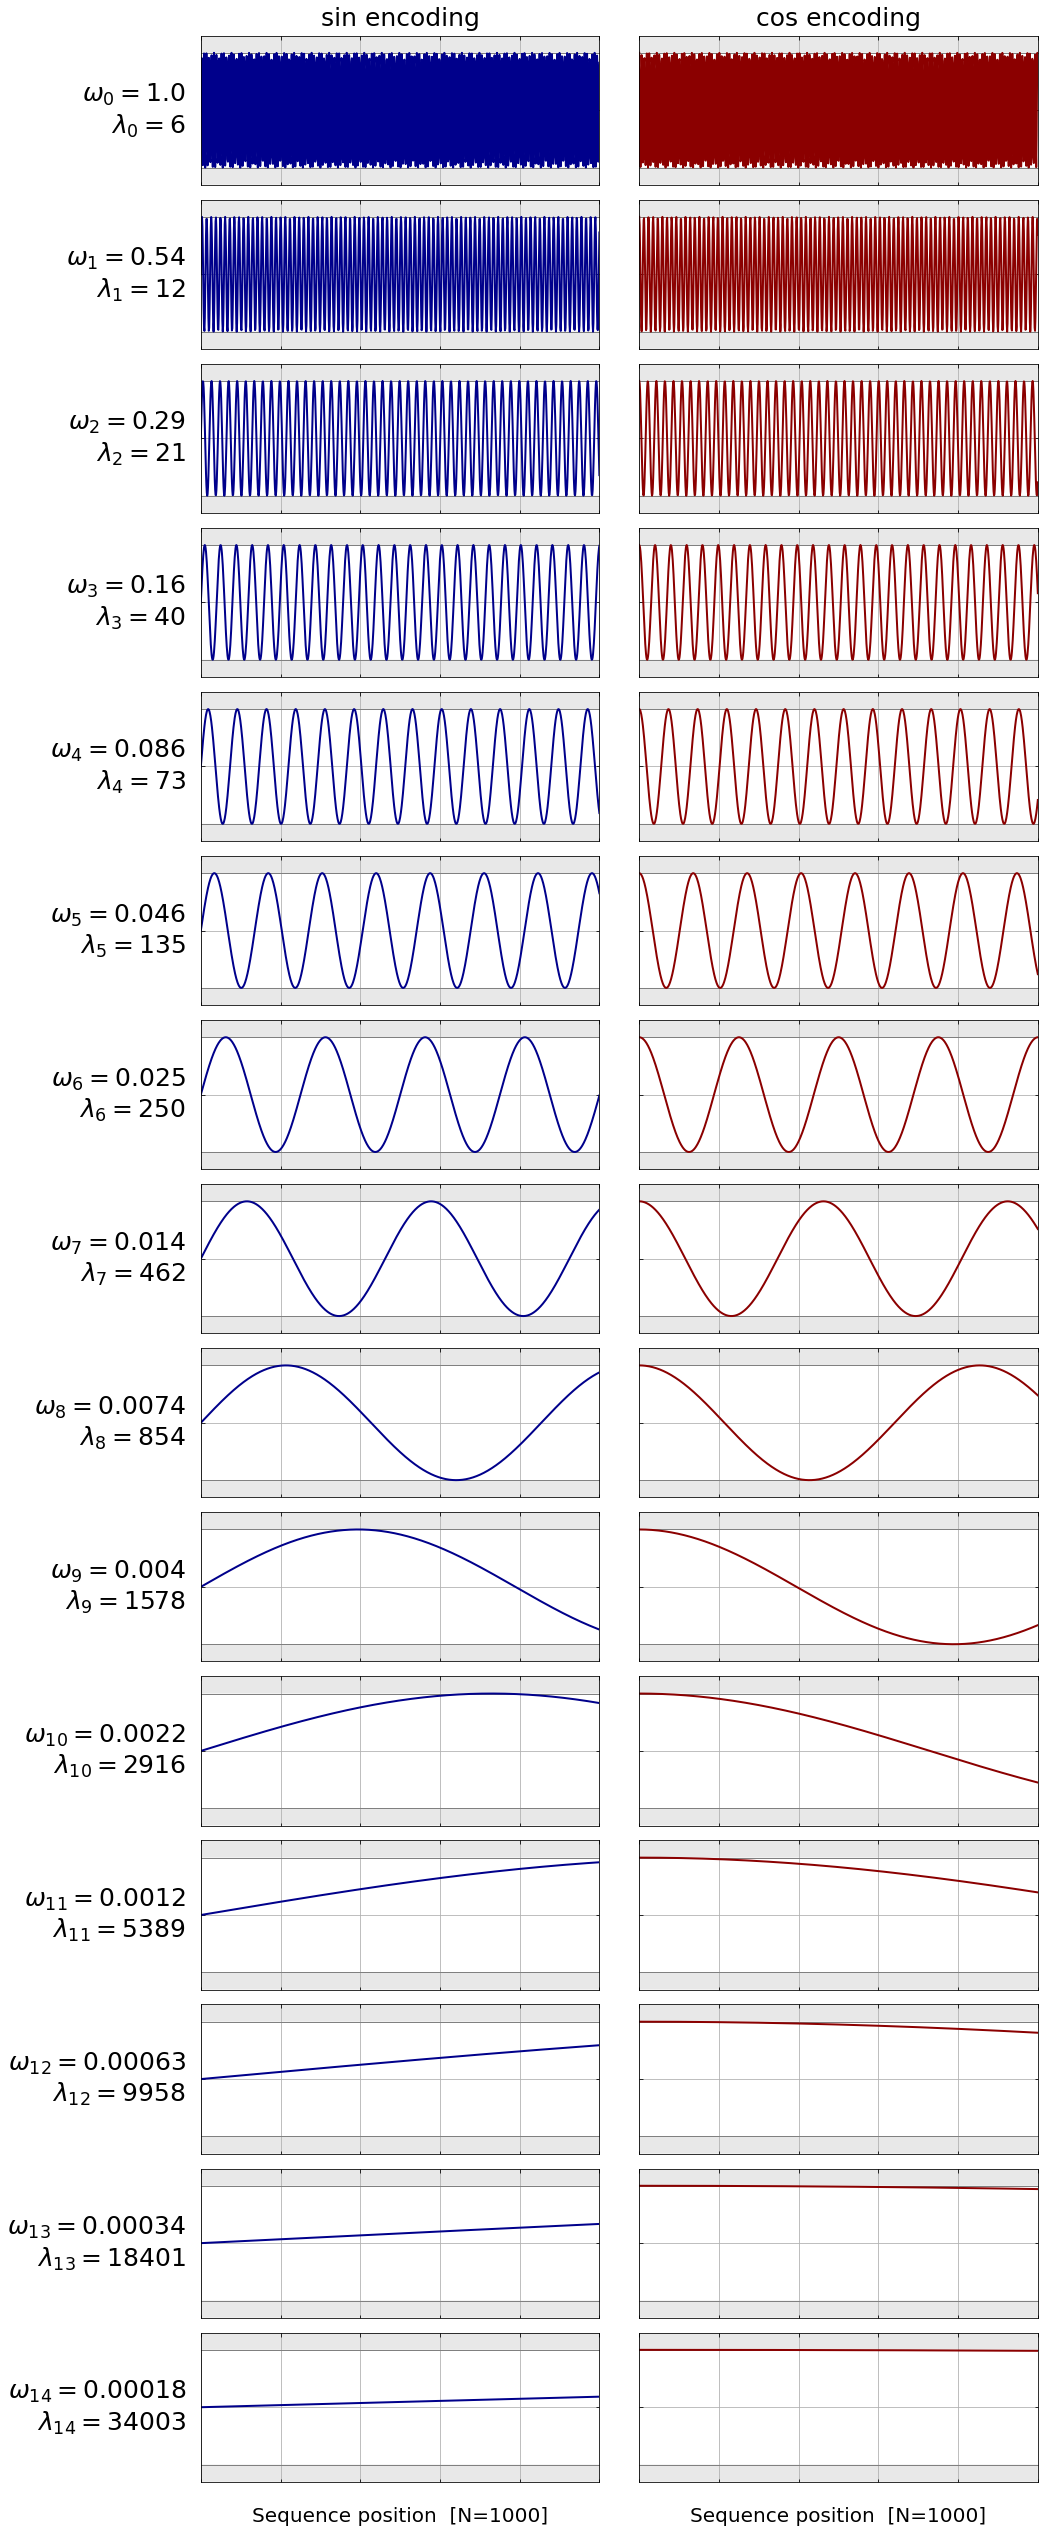

In [42]:
#=========================================================================================
#===  Calculate and plot position dependence for encoded features at different depths  ===
#=========================================================================================

##  Configurable constants
N      = 1000   #  length of sequence
half_d = 15     #  size of encoding, divided by 2 because d includes both sin and cos encodings

##  Create array of positions to calculate encodings for
p = np.linspace(0, N, 1001)

##  Get encodings
sin_encodings = sinusoid_encoding(p, half_d)
cos_encodings = sinusoid_encoding(p, half_d, phase_offset=np.pi/2)

##  Create temporary method for formatting axes, to avoid repeated code
def format_axis(ax, p, N) :
    ax.tick_params(which="both", axis="both", direction="in", labelsize=16, pad=5, right=True, top=True)
    
    ax.set_xlim([p.min(), p.max()])
    ax.set_ylim([-1.3, 1.3])
    
    ax.fill_between(p, -1.3, -1, lw=0, fc="lightgray", alpha=0.5)
    ax.fill_between(p,  1.3,  1, lw=0, fc="lightgray", alpha=0.5)
    ax.axhline(-1, ls="-", lw=1, c="gray")
    ax.axhline( 1, ls="-", lw=1, c="gray")
    
    ax.grid()
    
    ax.set_xlabel(f"Sequence position  [N={N}]", fontsize=20, labelpad=20, va="top")

##  Create figure
fig = plt.figure(figsize=(15, 3*half_d))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

##  Plot each direction of the encodings on different rows
for row_idx in range(half_d) :
    ax_sin = fig.add_subplot(half_d, 2, 2*row_idx + 1)
    ax_cos = fig.add_subplot(half_d, 2, 2*row_idx + 2)
    
    format_axis(ax_sin, p, N)
    format_axis(ax_cos, p, N)
    
    if row_idx == 0 :
        ax_sin.set_title("sin encoding", fontsize=25, pad=10)
        ax_cos.set_title("cos encoding", fontsize=25, pad=10)
        
    ax_sin.plot(p, sin_encodings[:,row_idx], lw=2, c="darkblue")
    ax_cos.plot(p, cos_encodings[:,row_idx], lw=2, c="darkred")
        
    ax_sin.yaxis.set_ticklabels([])
    ax_cos.yaxis.set_ticklabels([])
    
    omega = 10000**(-row_idx/half_d)
    lam   = (2*np.pi) / omega
    ax_sin.set_ylabel(f"$\omega_{{{row_idx}}} = {omega:.2}$\n$\lambda_{{{row_idx}}} = {lam:.0f}$", ha="right", va="center",
                      fontsize=25, rotation=0, labelpad=10)
    
    if row_idx != d-1 :
        ax_sin.xaxis.set_ticklabels([])
        ax_cos.xaxis.set_ticklabels([])
    
##  Show and close figure
plt.show(fig), 
fig.savefig("figures/positional_encodings_overview/frequencies.pdf", bbox_inches="tight")
plt.close()

Again, let's make a couple of notes
- Provided $d$ is configured high enough, there will exist at least one frequency to naturally capture correlations at any scale from $\mathcal{O}(1)$ to $\mathcal{O}(10k)$.
- For large $i$, the last `sin` encoding is effectively linear, so we even cover this "simple" approach
- For large $i$, the last `cos` encoding is effectively flat, which provides no information, but this isn't much of a problem
- The attention layer must have enough features to capture correlations at all scales in which sturcture exists in the data, since a linear combination of different wavelengths will not transform like either of them